<div style="font-size:30px;color:#3665af;background-color:#E9E9F5;padding:10px;">1. Deploy a Dataproc Cluster </div>


* <p>Set up a small cluster loaded with Spark.</p>
* <p>Connect to it</p>

Follow these instructions to deploy a Spark Dataproc Cluster. An example run of the command line steps are shown at
the bottom of this section. The symbol <span style="background-color: #fff0fa">$</span> in the following instructions represent your command line prompt, and does
not need to be copied.

<div style="font-size:20px;color:#F1F8FC;background-color:#0095EA;padding:10px;">1.1 To create your Dataproc Cluster, do the following:</div>

<p style="font-size:15px; "> <b>1.</b> We are assuming you still have a Project in Google Cloud. If you don't, <a href="https://cloud.google.com/resource-manager/docs/creating-managing-projects">create one</a>.</p>
<p style="font-size:15px; "> <b>2.</b> If you haven't yet, download and install <a href="https://cloud.google.com/sdk/">Google Cloud SDK</a>.</p>

<p style="font-size:15px; "> <b>3.</b> If you haven't yet, authenticate your Google SDK with your Google Cloud account.</p>

<p style="background-color: #f2f2f2; font-size:20px">$ gcloud auth login</p>

<p style="font-size:15px; "> <b>4.</b> If you haven't yet, associate your Google SDK with your Google Cloud project that you just created, using it's project name.</p>

<p style="background-color: #f2f2f2; font-size:20px">$ gcloud config set project [project name]</p>

<p style="font-size:15px; "> <b>5.</b> Create a storage bucket. Name your bucket whatever you want.</p>

<p style="background-color: #f2f2f2; font-size:20px">$ gsutil mb -c regional -l us-west1 gs://[bucket name] </p>

<p style="font-size:15px; "> <b>6.</b> We want to copy a public data set from Google BigQuery. We can use the <span style="background-color: #fff0fa">bq</span> utility for this. Again, replace
[bucket name] with your bucket's name. Since this is a very large file (1.2GB), we will use the wildcard format (*),
which allows BigQuery to export it as multiple files to our bucket.</p>

<p style="background-color: #f2f2f2; font-size:20px">$ bq extract 'bigquery-public-data:chicago_crime.crime' 'gs://[bucket name]/crime-*.csv'</p>

<p style="font-size:15px; "> <b>7.</b> We will be requesting 3 workers with 2 cores per worker, so we can demonstrate the speedup of distribution. Ideally we'd want to use more cores to really see the speedup, but we're limited by the quotas set during the Google Cloud trial. 
Dataproc has a variety of initialization scripts that you can choose from. We will be using their Miniconda installation script, which
will provide us with Python 3 PySpark (Python 3 is selected via the MINICONDA_VARIANT metadata argument)</p>



<p style="background-color: #f2f2f2; font-size:20px">gcloud dataproc clusters create [cluster-name] \    <br>
&emsp;&emsp;--project '[project-name]' \<br>
&emsp;&emsp;--bucket '[bucket-name]' \<br>
&emsp;&emsp;--metadata "MINICONDA_VARIANT=3" \<br>
&emsp;&emsp;--num-workers 3 \<br>
&emsp;&emsp;--properties spark:spark.executorEnv.PYTHONHASHSEED=0,spark:spark.yarn.am.memory=1024m \<br>
&emsp;&emsp;--worker-machine-type=n1-standard-2 \<br>
&emsp;&emsp;--master-machine-type=n1-standard-2 \<br>
&emsp;&emsp;--region us-west1 \<br>
&emsp;&emsp;--master-boot-disk-size=200GB \<br>
&emsp;&emsp;--worker-boot-disk-size=200GB 
</p>

This may take a few minutes to complete. If you get an error about exceeding your CPUs quota, make sure your REDIS instaces aren't still running (you can check under Computer Engine > VM Instances in the sidebar).

<p style="font-size:15px; "> <b>8.</b> Connect via SSH to the master node</p>

* <p>Go to <a href="https://console.cloud.google.com/">Google Cloud Console</a> </p>
* <p>Click Compute Engine > VM Instances . You should see something like this:</p>

![title](jupyter_connection.png "Picture")


* Your master node has your [cluster-name] followed by an <span style="background-color: #fff0fa">-m</span> . Click on the button labelled <span style="background-color: #fff0fa">SSH</span> for your master
node, under the "Connect" column. This will load a terminal.

<p style="font-size:15px; "> <b>9.</b> Once your terminal fully loads, install numpy, then run a Python Spark REPL (command in the cell below) from the command line of the master
node. The following command requests that PySpark is issued 16 cores from Yarn, which is the cluster manager
used in Dataproc clusters.</p>

<div class="alert alert-block alert-warning">
<b>NOTE: </b> Do not attempt this until your previous step has terminated.         
</div>

You're In!

<span style="font-size:35px">Example:</span>

<hr style="border-top: 5px solid purple; margin-top: 1px; margin-bottom: 1px"></hr>

<div style="font-size:30px;color:#3665af;background-color:#e1dfb1;padding:10px;">Exercise </div>

<div style="font-size:30px;color:#3665af;background-color:#E9E9F5;padding:10px;"> 2. Cluster Analysis of Crime Data</div>

We have a large set of crime data from the city of Chicago, Illinois. We have been asked by the city to find the optimal
placement of police stations based on this data, so that they can more quickly respond to violent crime. In order to
achieve this, we will use the [K-Means](https://en.wikipedia.org/wiki/K-means_clustering) algorithm, to find the geographic centroids for some number of data clusters. Meanwhile you will also: 

- set up a k-means clustering algorithm using Spark
- observe the runtime
- observe the silhouette coeffienct value for different clusters
- find a good k value

<div class="alert alert-block alert-warning">
<b>IMPORTANT</b> Use the seed value 0 for every KMeans algorithm you create. Example:
        
    Kmeans(seed = 0)

</div>

<div style="font-size:20px;color:#F1F8FC;background-color:#0095EA;padding:10px;">2.1 Setup</div>

<div class="alert alert-block alert-success">

#### The following code can be pasted into your PySpark [REPL](https://en.wikipedia.org/wiki/Read%E2%80%93eval%E2%80%93print_loop), which appears as a python prompt >>> :

```
# library dependencies
from datetime import datetime
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
```

#### Substitute your [bucket name] and paste in this line:

```
data_url = "gs://[bucket name]/crime-*.csv"
```

#### These lines will load in your data that we copied from BigQuery:

```
# read in our csv as a Spark DataFrame
raw_data = (
spark
.read
.option("header", "true") # the first line is used to create meaningful column names
.option("inferschema", "true") # infer the data types in each column
.option("mode", "DROPMALFORMED") # remove rows with values that are illegal
.csv(data_url) # the wildcard-embedded URL pattern to use
)#
# One liner
raw_data = (spark.read.option("header", "true").option("inferschema", "true").option("mode", "DROPMALFORMED").csv(data_url))   
#remove two outliers at position (0,0) - you're welcome! ;-)
raw_data = raw_data.where((raw_data.x_coordinate != 0) | (raw_data.y_coordinate != 0))
```
    
</div>

<div style="font-size:20px;color:#F1F8FC;background-color:#0095EA;padding:10px;">2.2 Create a Feature Column</div>

<div class="alert alert-block alert-success">
    
Spark requires us to collect our features into a single column. It supports many forms of [feature extraction](https://spark.apache.org/docs/latest/ml-features), for different data types and different algorithms. We will use a VectorAssembler to assemble our columns x_coordinate and y_coordinate into a 2D array on a new column named features.

#### Create a feature column
```
# use pyspark.ml.feature.VectorAssembler() to create a feature column
```
    
</div>

<div style="font-size:20px;color:#F1F8FC;background-color:#0095EA;padding:10px;">2.3 A test of K-Means</div>

<div class="alert alert-block alert-success">

We can run Apache Spark's built-in [KMeans](https://spark.apache.org/docs/2.2.0/api/python/pyspark.mllib.html#pyspark.mllib.clustering.KMeans) algorithm to attempt to find any finite number of clusters. <b> Run a K-Means model with k=2 </b>. See the [documentation](http://spark.apache.org/docs/2.2.0/ml-clustering.html) for clustering in Apache Spark for an example. Again, please set your seed value to 0.
    
#### Show the cluster centers and wssse value below
    
</div>

<div style="font-size:20px;color:#F1F8FC;background-color:#0095EA;padding:10px;">2.4 Exporting k with respect to runtime</div>

<div class="alert alert-block alert-success">
    
As k increases, we increase the work required to train our model. We should expect the duration of model training to increase. How does running this on a compute cluster compare to running it on our own computer?

<b>Run K-Means with k={2,102,202,302,402}. Run each k value a couple of times and average the result. Capture the runtime by surrounding only the model training code with calls to datetime.now()</b>. 

    Note: It may save you time to wrap your model in a for loop, iterating over a range() of k values.

Here are time values for training at different k values on a local deployment of Apache Spark on a Quad Core i7 with 16GB RAM:

</div>
    
| k | local runtime |
| :-: | :-: |
| 2 | 0:00:32.240732 |
| 102 | 0:01:32.956807 |
| 202 | 0:02:19.142536 |
| 302 | 0:02:53.870777 |
| 402 | 0:03:23.362213 |
    


<div class="alert alert-block alert-success">
    
#### What runtimes did you observe for these values of k?
    
</div>

<div class="alert alert-block alert-success">

<b>Informally describe the speedup you observed in this experiment</b>, with respect to
the degree of parallelism, compared to the runtimes on the Quad Core i7. for example:
"speed improved on average by 8x when we increased the number of cores by 4x."
    
</div>

<div style="font-size:20px;color:#F1F8FC;background-color:#0095EA;padding:10px;">2.5 Solving the Problem</div>

<div class="alert alert-block alert-success">

Our approach is fine, but there is a flaw. We have not truly addressed the problem that was posed to us. The Chicago Police requested that we find ideal locations to help them respond to violent crime. How can we address this? Consider the [Illinois IUCR Categories for violent crime](https://home.chicagopolice.org/statistics-data/statistical-reports/), and filter our dataset to more appropriately address violent crime.
    
</div>

<div class="alert alert-block alert-success">
    
#### How did you choose to represent "violent crime"?
    
</div>

<div class="alert alert-block alert-success">
    
#### What is the resulting size of our training set?
    
</div>

<div style="font-size:20px;color:#F1F8FC;background-color:#0095EA;padding:10px;">2.6 Finding a good value for k</div>

<div class="alert alert-block alert-success">

We can evaluate our Spark KMeans algorithm using a method called the silhouette method. From the [documentation](https://spark.apache.org/docs/latest/ml-clustering.html), the optimal k is usually one where there is an efficient silhouette coefficient value in the silhouette graph, where silhouette value is the output of evaluate(). Let's try exploring these silhouette coefficient values and see if we can find the best silhouette coefficient for different clusters. You can think of it visually as a range of values between [-1,1] where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. <br>(https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) <br><br>

To do this, capture the silhouette coefficient value for many successive values of k. You will have to explore to find a meaningful range for these k values. For each value, run KMeans() and fit() it, print() and visualize both k and silhouette coefficient values for each model. Use matplotlib to plot your output. Make sure to save your plot to a file, you'll need to transer this image from the DataProc cluster and submit it with your assignment. 
    
</div>

<div class="alert alert-block alert-success">
    
#### What is the optimal k value that you have selected?
    
</div>

<div class="alert alert-block alert-success">
    
#### Please provide the cluster centers that you have found for your model with your chosen k.
    
</div>

<div class="alert alert-block alert-success">
        
#### Please include your silhouette coefficient value plot.
    
</div>

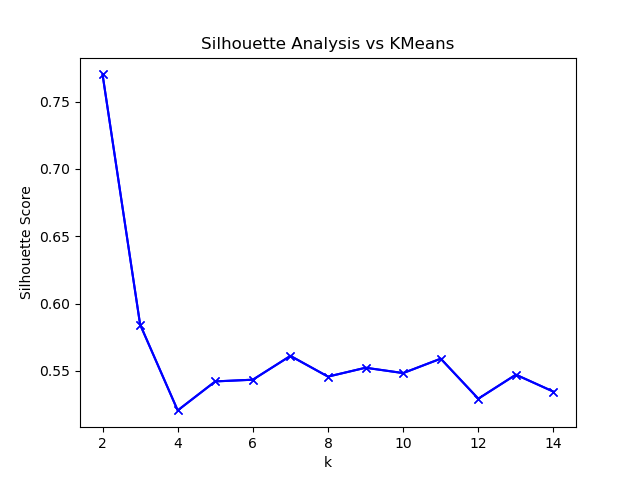

In [1]:
## Include your plot with your submission on Canvas, and list the file name you used here. 
## You can use the "Download File" button in the Google Cloud SSH window to download your plot. 

from IPython.display import Image
Image(filename='silhouette_graph.png')


<div class="alert alert-block alert-success">
    
#### Be sure to share your new knowledge with any friends you have in Chicago.
    
</div>

<div style="font-size:20px;color:#F1F8FC;background-color:#0095EA;padding:10px;">2.7 Plot your cluster centers</div>

Export the cluster centers from your final model, and plot them in a scatter plot using Jupyter and matplotlib.

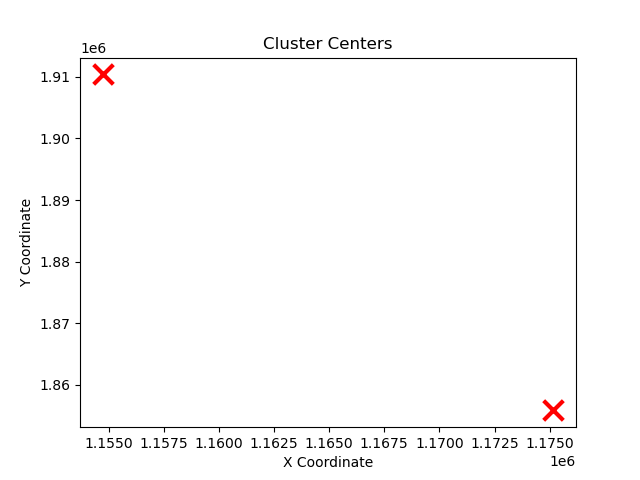

In [2]:
from IPython.display import Image
Image(filename='final_plot.png')

<hr style="border-top: 5px solid purple; margin-top: 1px; margin-bottom: 1px"></hr>